이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 영어/한국어 Word2Vec 실습 학습 자료입니다.  
링크 : https://wikidocs.net/50739

In [1]:
import gensim
gensim.__version__

'4.3.2'

In [2]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.8 MB/s eta 0:00:00


# 1. 영어 Word2Vec

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [5]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x78d09c170340>)

In [6]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [7]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [8]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [11]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

여기서 Word2Vec의 인자는 다음과 같습니다.  

* vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* window = 컨텍스트 윈도우 크기
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* workers = 학습을 위한 프로세스 수
* sg = 0은 CBOW, 1은 Skip-gram.

In [12]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8475987315177917), ('guy', 0.7962682843208313), ('lady', 0.7910979986190796), ('gentleman', 0.740517795085907), ('boy', 0.7403030395507812), ('girl', 0.7230278849601746), ('soldier', 0.7027288675308228), ('kid', 0.6998494863510132), ('poet', 0.6820068955421448), ('physicist', 0.6684714555740356)]


In [13]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [14]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8475987315177917), ('guy', 0.7962682843208313), ('lady', 0.7910979986190796), ('gentleman', 0.740517795085907), ('boy', 0.7403030395507812), ('girl', 0.7230278849601746), ('soldier', 0.7027288675308228), ('kid', 0.6998494863510132), ('poet', 0.6820068955421448), ('physicist', 0.6684714555740356)]


# 2. 한국어 Word2Vec

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [16]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x78d065c78760>)

In [17]:
train_data = pd.read_table('ratings.txt')

In [18]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [19]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 200000


In [20]:
print('NULL 값 존재 유무 :', train_data.isnull().values.any())

NULL 값 존재 유무 : True


In [21]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('NULL 값 존재 유무 :', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

NULL 값 존재 유무 : False


In [22]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 199992


In [23]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-23-d10eedfa8951>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [24]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [25]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (실행 20분 정도 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [19:53<00:00, 167.59it/s]


In [27]:
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다'], ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고']]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


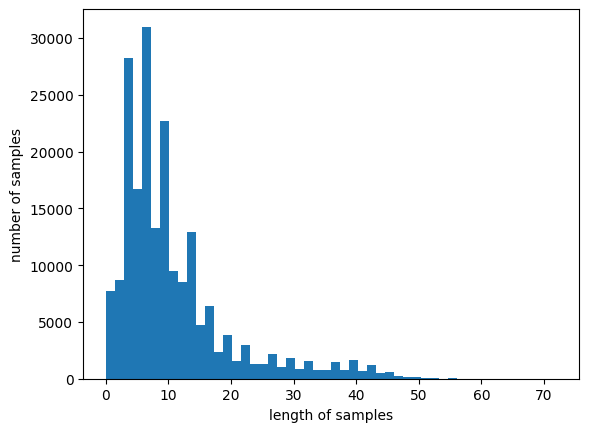

In [28]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
from gensim.models import Word2Vec

In [31]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [32]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (16477, 100)


In [33]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8795193433761597), ('안성기', 0.8745977282524109), ('김명민', 0.8648231625556946), ('김수현', 0.8571472764015198), ('박중훈', 0.8523020148277283), ('송강호', 0.8382790088653564), ('설경구', 0.8279197812080383), ('윤제문', 0.8265255093574524), ('엄태웅', 0.8250567317008972), ('이민호', 0.8234192728996277)]


In [34]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8624646663665771), ('느와르', 0.8582134246826172), ('호러', 0.8564848303794861), ('물의', 0.851243793964386), ('블랙', 0.8409926891326904), ('무협', 0.8357768654823303), ('블록버스터', 0.8331990242004395), ('무비', 0.8258812427520752), ('헐리우드', 0.8137089014053345), ('물', 0.8070505261421204)]


In [35]:
print(model.wv.most_similar("발연기"))

[('연기', 0.758121132850647), ('어색', 0.7345728874206543), ('연기력', 0.7304934859275818), ('발음', 0.7244566679000854), ('조연', 0.7157142758369446), ('사투리', 0.7052367925643921), ('캐스팅', 0.6964720487594604), ('미스캐스팅', 0.6796514391899109), ('주연', 0.659852147102356), ('신하균', 0.6586893796920776)]


# 3. 사전 훈련된 Word2Vec

In [36]:
import gensim
import urllib.request

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
## 원래 예제 코드: 해당 파일이 없어 에러가 발생함
# urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                           filename="GoogleNews-vectors-negative300.bin.gz")

## 수정된 코드
# 1. 사전 학습된 Word2Vec 파일을 아래 링크에서 다운로드
#    https://code.google.com/archive/p/word2vec/
#      or
#    https://drive.google.com/file/d/1ikNHEMqN0RYFwFf0m9t1Jr0hei_Hehqu/view?usp=share_link

# 2. 자신의 구글 드라이브에 다운로드 받은 파일을 업로드하고 마운트한 후 해당 파일 경로를 복사하여 아래 코드에 추가
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/공유/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [40]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [41]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [42]:
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04